In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.utils as utils

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.vae_lstm import LSTMVAE
from src.vae_dense import DenseVAE
from src.vae_conv import ConvVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

2023-12-22 15:26:39.157811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Hyperparams

In [3]:
# HYPERPARAMS
N_EPOCHS: int = 256
N_BATCHES: int = 4
VAL_SPLIT: float = 0.2
DROPOUT_RATE: float = 0.1          # Only for DenseVAE
RECONSTRUCTION_WEIGHT: int = 3      # Weight of reconstruction_loss in total_loss metric

# Size of the latent dimension
LATENT_DIM: int = 5

# Settings to save model and history / comparison plots
SAVE_MODEL: bool = False     # If set to true, model will be saved under ../models/ dir
MODEL_ID: str = utils.get_model_id(N_EPOCHS, N_BATCHES, VAL_SPLIT, LATENT_DIM)

# Load Data

In [4]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-22 15:26:45,820 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-22 15:27:01,694 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [5]:
CONDITIONS = ["MathxEasy", "MathxMedium", "MathxHard"]
pp_data = {}

for i, condition in enumerate(CONDITIONS):
    preprocessor = Preprocesser(df_list=df_list, condition=condition, partition_size=250, fixed_size=10990)
    tensor: np.array = preprocessor.preprocess_data()
    FEATURE_NAMES = list(preprocessor.df_list_processed[0].columns)
    pp_data[condition] = {
        "tensor": tensor,
        "condition": condition,
        "condition_encoded": i,
        "condition_df": pd.DataFrame([condition for n in range(0, tensor.shape[0])]),
        "condition_encoded_df": pd.DataFrame([i for n in range(0, tensor.shape[0])]),
        "feature_names": FEATURE_NAMES,
        "scaler_object": preprocessor.scaler
    }


2023-12-22 15:27:02,021 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxEasy, Partition Size: 250, Fixed Size: 10990) ...
2023-12-22 15:27:02,331 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-22 15:27:02,342 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.32s) ...
2023-12-22 15:27:02,346 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxMedium, Partition Size: 250, Fixed Size: 10990) ...
2023-12-22 15:27:02,617 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-22 15:27:02,625 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.28s) ...
2023-12-22 15:27:02,627 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Partition Size: 250, Fixed Size: 10990) ...
2023-12-22 15:27:02,884 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-22 15:27:02,893 - src.preprocessing - INFO - Finished preprocessing 

In [6]:
# Stack data of each condition to one single 3D numpy array (input data to model)
tensor = np.concatenate([pp_data[key]["tensor"] for key in pp_data.keys()], axis=0)
condition_df = pd.concat(pp_data[key]["condition_df"] for key in pp_data.keys())

print(f"Shape of Input Data: {tensor.shape}")
print(f"Shape of condition_df: {condition_df.shape}")

Shape of Input Data: (1290, 250, 7)
Shape of condition_df: (1290, 1)


# Modelling

In [7]:
#vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT)
vae = DenseVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT, dropout_rate = DROPOUT_RATE)
#vae = ConvVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT)

vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

In [8]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 7)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 1750)                 0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  448256    ['flatten[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256)                  0         ['dense[0][0]']               
                                                                                            

In [9]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_5 (Dense)             (None, 16)                96        
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 128)               8320

In [10]:
history = vae.fit(tensor, epochs=N_EPOCHS, batch_size=N_BATCHES,
                  validation_split=VAL_SPLIT, shuffle=True)#,
                  #callbacks=[ReduceLROnPlateau(monitor="val_loss", patience=7), EarlyStopping(monitor="val_loss", patience=12)])

Epoch 1/256
258/258 [==============================] - 6s 14ms/step - loss: 183.8117 - reconstruction_loss: 29.7937 - kl_loss: 8.6929 - val_loss: 62.3120 - val_reconstruction_loss: 12.8675 - val_kl_loss: 23.7096
Epoch 2/256
258/258 [==============================] - 2s 9ms/step - loss: 64.8935 - reconstruction_loss: 19.4238 - kl_loss: 5.6645 - val_loss: 61.4002 - val_reconstruction_loss: 13.4579 - val_kl_loss: 21.0265
Epoch 3/256
258/258 [==============================] - 3s 10ms/step - loss: 61.2046 - reconstruction_loss: 18.7504 - kl_loss: 4.6321 - val_loss: 48.7810 - val_reconstruction_loss: 11.3266 - val_kl_loss: 14.8011
Epoch 4/256
258/258 [==============================] - 3s 10ms/step - loss: 59.1415 - reconstruction_loss: 17.3636 - kl_loss: 4.4343 - val_loss: 47.9715 - val_reconstruction_loss: 11.2226 - val_kl_loss: 14.3037
Epoch 5/256
258/258 [==============================] - 3s 12ms/step - loss: 54.4779 - reconstruction_loss: 16.4224 - kl_loss: 3.9981 - val_loss: 46.9345 - v

Epoch 40/256
258/258 [==============================] - 2s 7ms/step - loss: 33.6519 - reconstruction_loss: 10.1785 - kl_loss: 3.8320 - val_loss: 43.6172 - val_reconstruction_loss: 10.2107 - val_kl_loss: 12.9850
Epoch 41/256
258/258 [==============================] - 2s 7ms/step - loss: 34.4910 - reconstruction_loss: 10.3987 - kl_loss: 3.8108 - val_loss: 42.5140 - val_reconstruction_loss: 10.0099 - val_kl_loss: 12.4843
Epoch 42/256
258/258 [==============================] - 2s 7ms/step - loss: 33.4267 - reconstruction_loss: 9.9446 - kl_loss: 3.9328 - val_loss: 44.3416 - val_reconstruction_loss: 10.5352 - val_kl_loss: 12.7358
Epoch 43/256
258/258 [==============================] - 2s 7ms/step - loss: 34.5701 - reconstruction_loss: 10.5603 - kl_loss: 4.0235 - val_loss: 43.1846 - val_reconstruction_loss: 9.7257 - val_kl_loss: 14.0074
Epoch 44/256
258/258 [==============================] - 2s 7ms/step - loss: 33.7621 - reconstruction_loss: 9.9570 - kl_loss: 4.0836 - val_loss: 42.3323 - val_

Epoch 79/256
258/258 [==============================] - 2s 7ms/step - loss: 31.6678 - reconstruction_loss: 9.4376 - kl_loss: 3.9659 - val_loss: 43.7127 - val_reconstruction_loss: 10.3740 - val_kl_loss: 12.5908
Epoch 80/256
258/258 [==============================] - 2s 7ms/step - loss: 31.3373 - reconstruction_loss: 9.3554 - kl_loss: 3.9689 - val_loss: 42.4353 - val_reconstruction_loss: 9.8703 - val_kl_loss: 12.8244
Epoch 81/256
258/258 [==============================] - 2s 7ms/step - loss: 31.7351 - reconstruction_loss: 9.1444 - kl_loss: 4.2052 - val_loss: 42.7948 - val_reconstruction_loss: 10.0542 - val_kl_loss: 12.6323
Epoch 82/256
258/258 [==============================] - 2s 7ms/step - loss: 30.3312 - reconstruction_loss: 9.2214 - kl_loss: 3.9031 - val_loss: 43.5242 - val_reconstruction_loss: 10.0790 - val_kl_loss: 13.2873
Epoch 83/256
258/258 [==============================] - 2s 7ms/step - loss: 31.9395 - reconstruction_loss: 9.1813 - kl_loss: 3.9921 - val_loss: 44.9079 - val_rec

Epoch 118/256
258/258 [==============================] - 2s 7ms/step - loss: 31.5028 - reconstruction_loss: 8.9738 - kl_loss: 4.3844 - val_loss: 44.4267 - val_reconstruction_loss: 10.2254 - val_kl_loss: 13.7505
Epoch 119/256
258/258 [==============================] - 2s 7ms/step - loss: 31.3867 - reconstruction_loss: 9.1241 - kl_loss: 4.2135 - val_loss: 44.4693 - val_reconstruction_loss: 10.0497 - val_kl_loss: 14.3203
Epoch 120/256
258/258 [==============================] - 2s 7ms/step - loss: 31.3190 - reconstruction_loss: 8.9178 - kl_loss: 4.0984 - val_loss: 43.2183 - val_reconstruction_loss: 9.9547 - val_kl_loss: 13.3541
Epoch 121/256
258/258 [==============================] - 2s 7ms/step - loss: 32.6943 - reconstruction_loss: 9.4781 - kl_loss: 4.1833 - val_loss: 45.8515 - val_reconstruction_loss: 10.1859 - val_kl_loss: 15.2939
Epoch 122/256
258/258 [==============================] - 2s 7ms/step - loss: 31.4403 - reconstruction_loss: 9.1931 - kl_loss: 4.2613 - val_loss: 46.3348 - va

Epoch 157/256
258/258 [==============================] - 2s 7ms/step - loss: 30.6451 - reconstruction_loss: 9.1568 - kl_loss: 3.9722 - val_loss: 44.0743 - val_reconstruction_loss: 10.0192 - val_kl_loss: 14.0167
Epoch 158/256
258/258 [==============================] - 2s 7ms/step - loss: 30.8712 - reconstruction_loss: 9.0285 - kl_loss: 4.0783 - val_loss: 43.0764 - val_reconstruction_loss: 9.9104 - val_kl_loss: 13.3451
Epoch 159/256
258/258 [==============================] - 2s 7ms/step - loss: 29.9567 - reconstruction_loss: 8.8610 - kl_loss: 4.0807 - val_loss: 44.7806 - val_reconstruction_loss: 10.3697 - val_kl_loss: 13.6714
Epoch 160/256
258/258 [==============================] - 2s 7ms/step - loss: 29.7186 - reconstruction_loss: 8.7939 - kl_loss: 3.9491 - val_loss: 43.2531 - val_reconstruction_loss: 10.1153 - val_kl_loss: 12.9072
Epoch 161/256
258/258 [==============================] - 2s 7ms/step - loss: 31.9536 - reconstruction_loss: 9.8345 - kl_loss: 4.1756 - val_loss: 43.2306 - va

Epoch 196/256
258/258 [==============================] - 2s 7ms/step - loss: 31.5253 - reconstruction_loss: 9.2316 - kl_loss: 4.3285 - val_loss: 45.1496 - val_reconstruction_loss: 10.0065 - val_kl_loss: 15.1300
Epoch 197/256
258/258 [==============================] - 2s 7ms/step - loss: 32.9926 - reconstruction_loss: 9.1660 - kl_loss: 4.1930 - val_loss: 44.9909 - val_reconstruction_loss: 10.6677 - val_kl_loss: 12.9878
Epoch 198/256
258/258 [==============================] - 2s 7ms/step - loss: 37.7152 - reconstruction_loss: 10.8367 - kl_loss: 3.8129 - val_loss: 42.9774 - val_reconstruction_loss: 9.9296 - val_kl_loss: 13.1886
Epoch 199/256
258/258 [==============================] - 2s 7ms/step - loss: 32.4131 - reconstruction_loss: 9.5023 - kl_loss: 4.0259 - val_loss: 43.1973 - val_reconstruction_loss: 9.8419 - val_kl_loss: 13.6717
Epoch 200/256
258/258 [==============================] - 2s 7ms/step - loss: 32.5541 - reconstruction_loss: 9.4094 - kl_loss: 4.2819 - val_loss: 46.1389 - va

Epoch 235/256
258/258 [==============================] - 2s 7ms/step - loss: 34.8984 - reconstruction_loss: 9.5489 - kl_loss: 4.1387 - val_loss: 48.5484 - val_reconstruction_loss: 11.3423 - val_kl_loss: 14.5214
Epoch 236/256
258/258 [==============================] - 2s 7ms/step - loss: 31.5436 - reconstruction_loss: 9.4356 - kl_loss: 4.1490 - val_loss: 51.4483 - val_reconstruction_loss: 11.7173 - val_kl_loss: 16.2965
Epoch 237/256
258/258 [==============================] - 2s 7ms/step - loss: 33.6935 - reconstruction_loss: 9.3129 - kl_loss: 4.1354 - val_loss: 46.4194 - val_reconstruction_loss: 10.8498 - val_kl_loss: 13.8699
Epoch 238/256
258/258 [==============================] - 2s 7ms/step - loss: 32.0300 - reconstruction_loss: 9.0477 - kl_loss: 4.1778 - val_loss: 46.8070 - val_reconstruction_loss: 10.8923 - val_kl_loss: 14.1300
Epoch 239/256
258/258 [==============================] - 2s 7ms/step - loss: 32.6026 - reconstruction_loss: 9.0476 - kl_loss: 4.0952 - val_loss: 48.1642 - v

# Save Model

In [11]:
if SAVE_MODEL:
    # Do a forward pass once to allow saving ...
    x = vae.predict(np.expand_dims(tensor[0], axis=0))

    print(f"Saving Model as '{MODEL_ID}' in models/ dir")
    vae.save(f"../models/{MODEL_ID}")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Analyse History

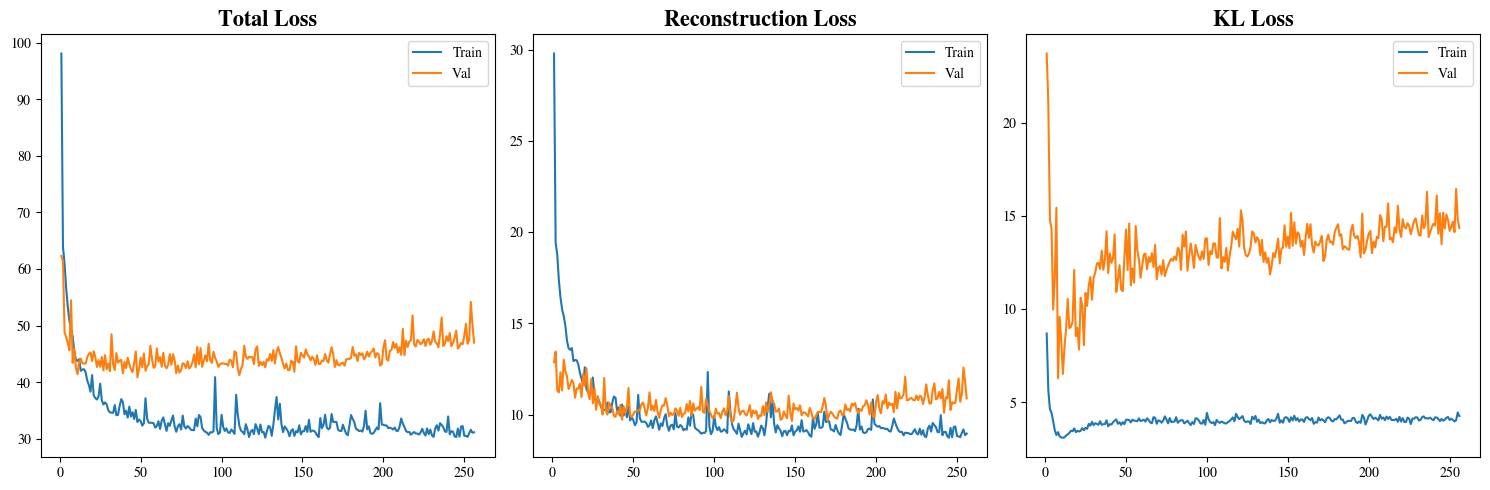

In [12]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved History in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/history.png")


plot_history(history)

# Reconstruction Plotting

In [39]:
SAMPLE_IDX_TO_VISUALIZE: int = 430

train_sample = np.expand_dims(tensor[SAMPLE_IDX_TO_VISUALIZE], axis=0)
train_sample_condition = condition_df.iloc[SAMPLE_IDX_TO_VISUALIZE, 0]
print(f"Shape of train_sample to visualize: {train_sample.shape} with condition '{train_sample_condition}'")

Shape of train_sample to visualize: (1, 250, 7) with condition 'MathxMedium'


In [40]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 0s 19ms/step


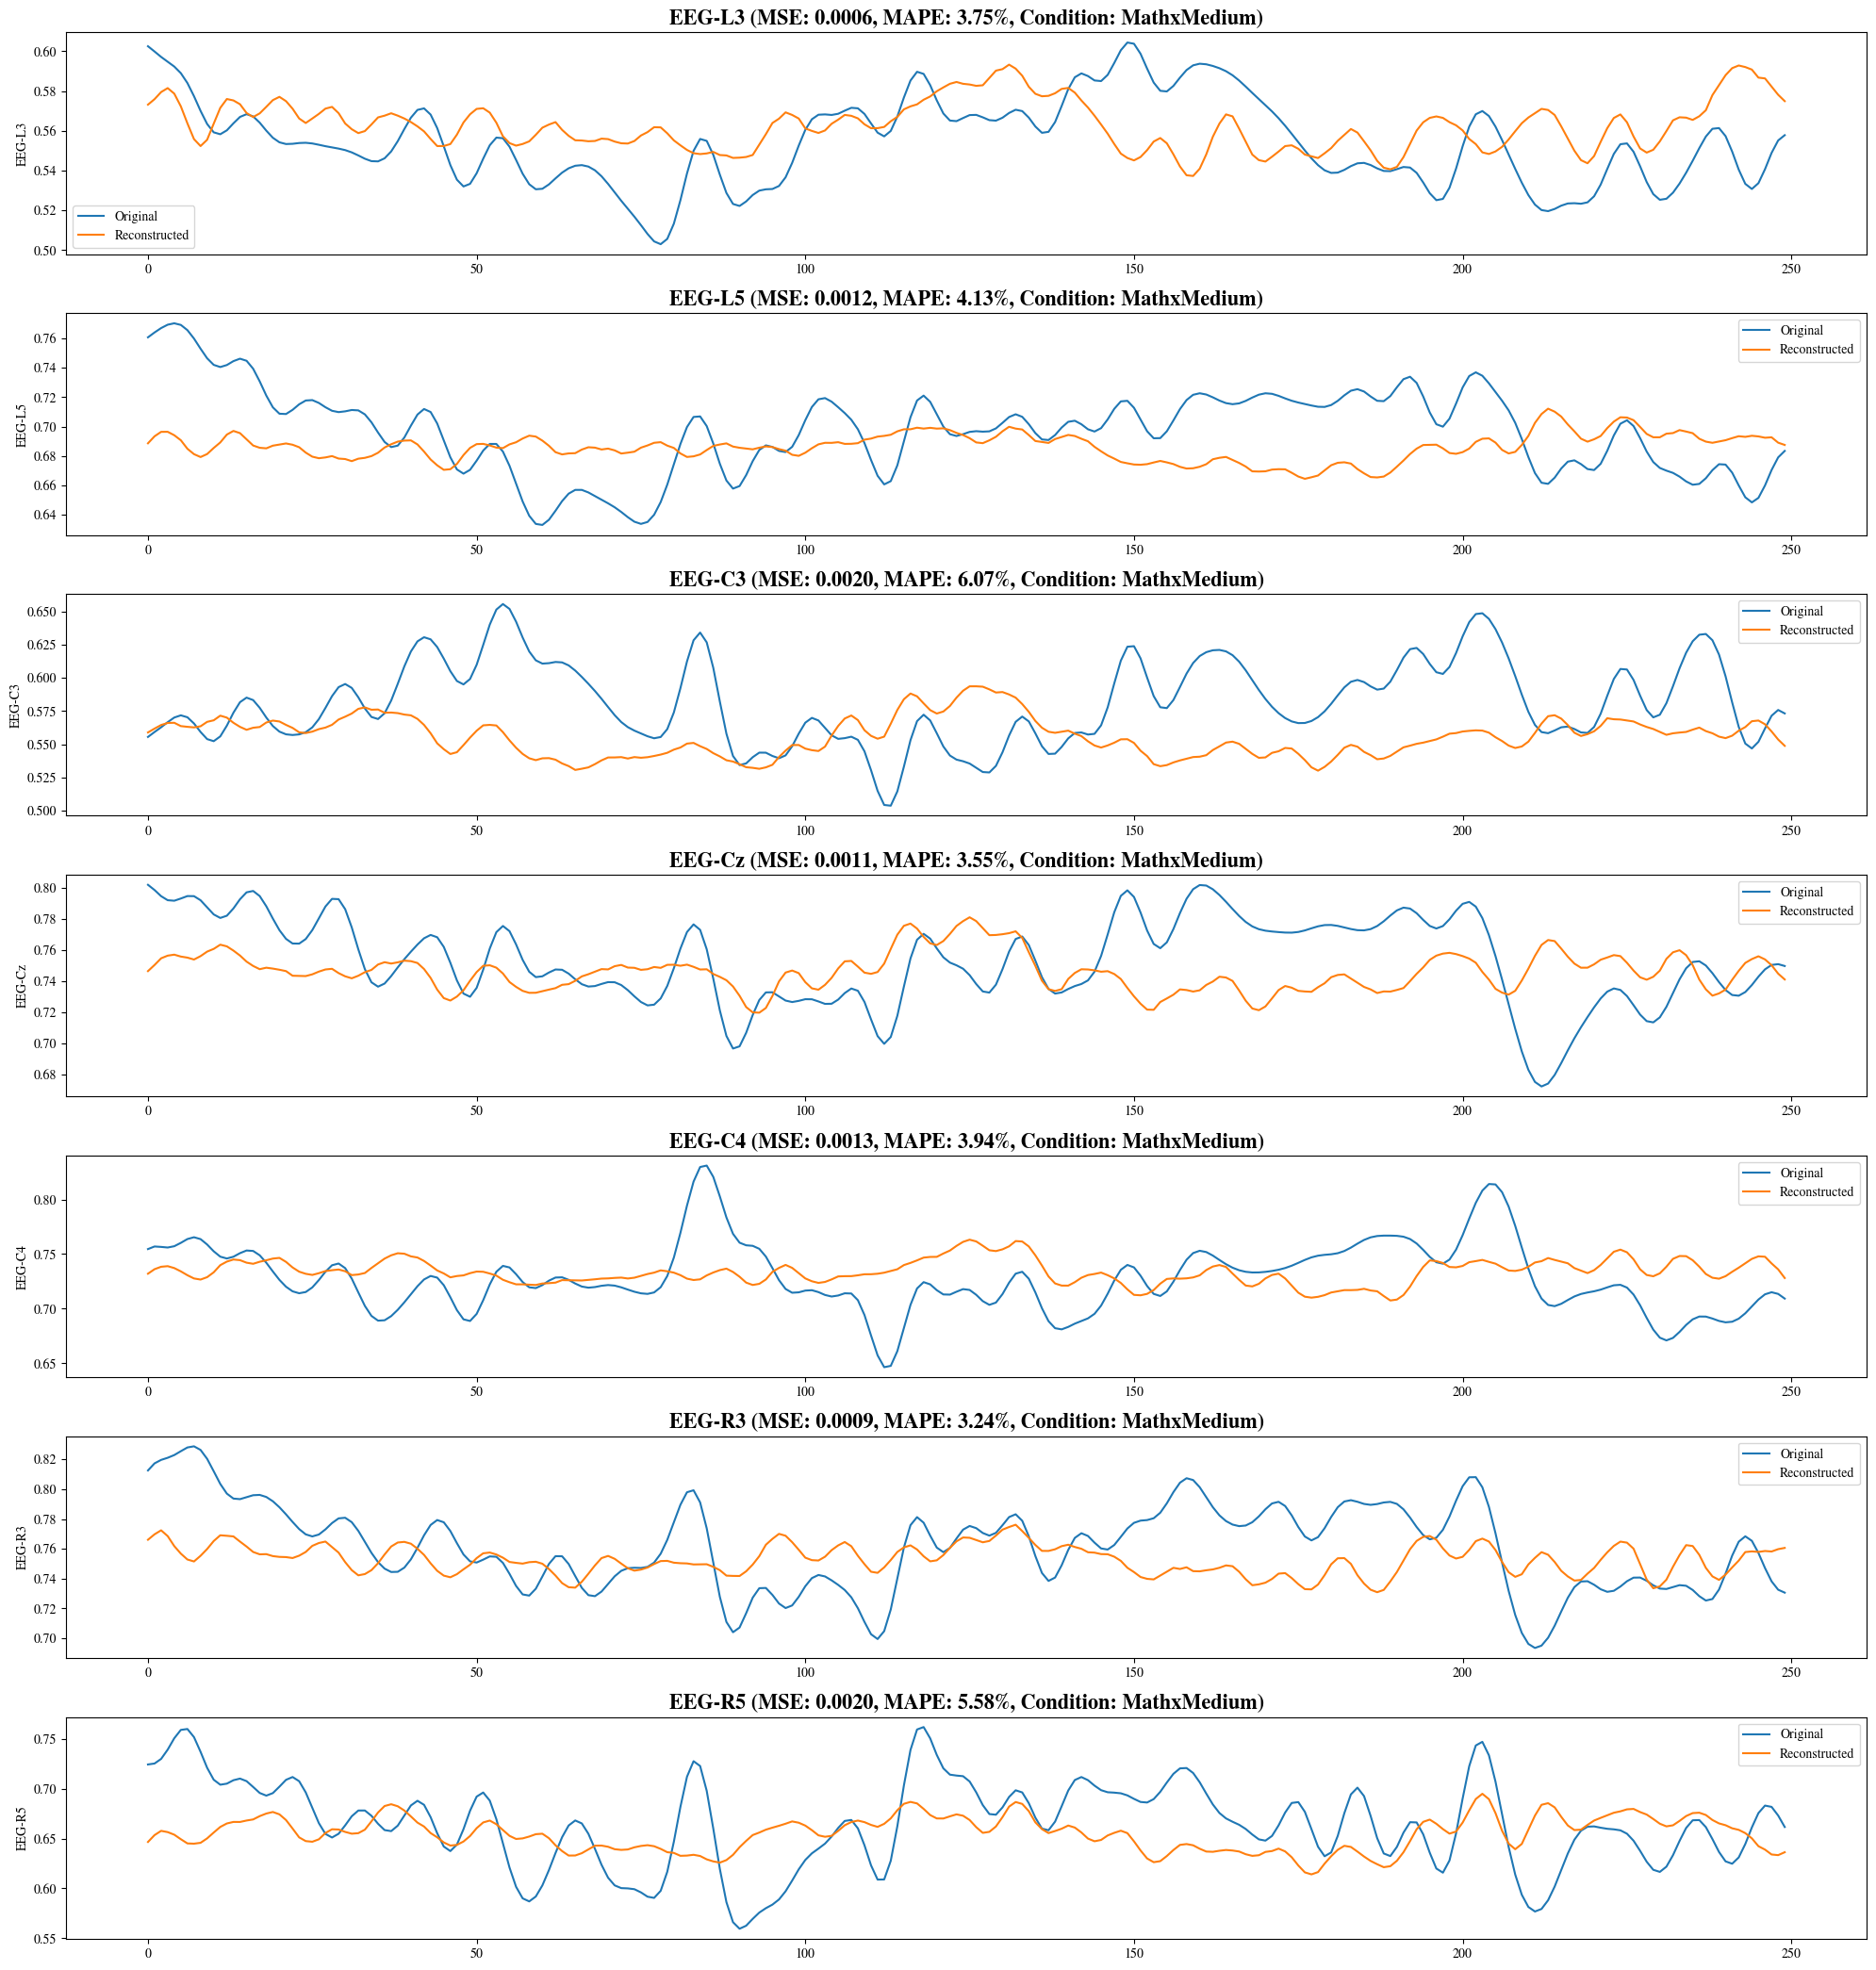

In [41]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array, condition: str) -> None:
    # Compute MSE and MAPE along the rows, for each column
    mse = np.mean(((train_sample[0] - train_sample_reconstructed[0])**2), axis=0)
    mape = np.mean(np.abs((train_sample[0] - train_sample_reconstructed[0]) / train_sample[0]), axis=0) * 100

    # Convert to pd.DataFrame for plotting reasons
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for i, (col, ax) in enumerate(zip(FEATURE_NAMES, axes.flatten())):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(f"{col} (MSE: {mse[i]:.4f}, MAPE: {mape[i]:.2f}%, Condition: {condition})", fontweight="bold", size=16)
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved Comparison in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/comparison.png")


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0], condition=train_sample_condition)

# Generate new Samples by Sampling from latent space

In [16]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


In [17]:
def plot_all_time_series(X: np.array) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param x: np.array -- Input data of shape (N_SEQ, N_FEATS)
    :param time_col: str -- Name of the time column
    :return: None
    """
    df = pd.DataFrame(X, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(20, len(df.columns)*3))
    for col, ax in zip(df.columns, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

#plot_all_time_series(synthetic_time_series[0])

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [18]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)
z_mean.shape

TensorShape([1290, 5])

## Visualize using TSNE

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(perplexity=30)
z_dim_reduced = tsne.fit_transform(z_mean)

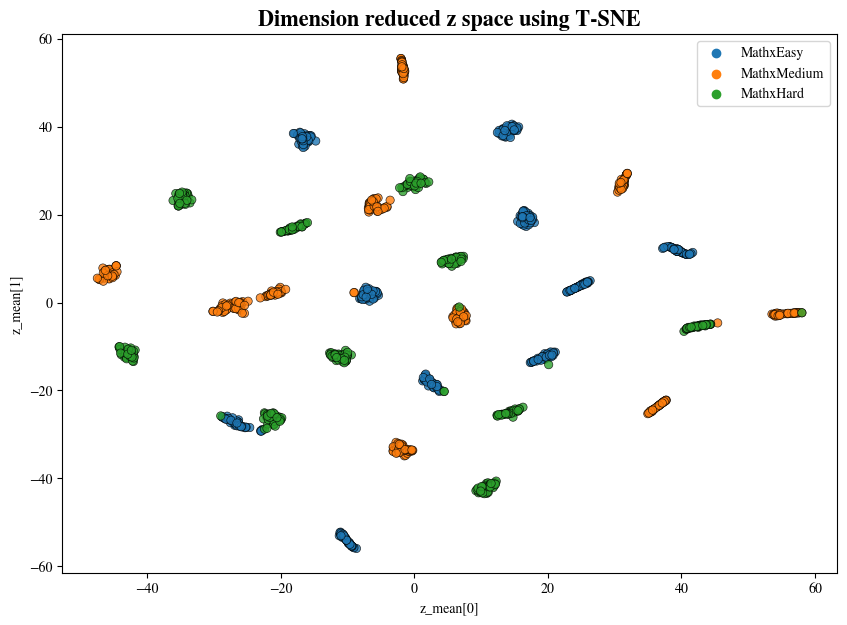

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8, hue=condition_df.values[:,0])
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

## Visualize using PCA

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N_PCS: int = 2
N_CLUSTERS: int = 3
    
pca = PCA(n_components=N_PCS, random_state=42)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)

In [23]:
z_dim_reduced_pca = pca.fit_transform(z_mean)
labels = kmeans.fit(z_mean).labels_

In [24]:
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
pca.explained_variance_ratio_

Total Explained Variance: 1.00


array([0.56137238, 0.4379704 ])

In [25]:
centroids = pca.transform(kmeans.cluster_centers_)
centroids

array([[-0.27319916,  0.66757611],
       [ 0.93318332, -0.24011928],
       [-0.9940816 , -0.77010148]])

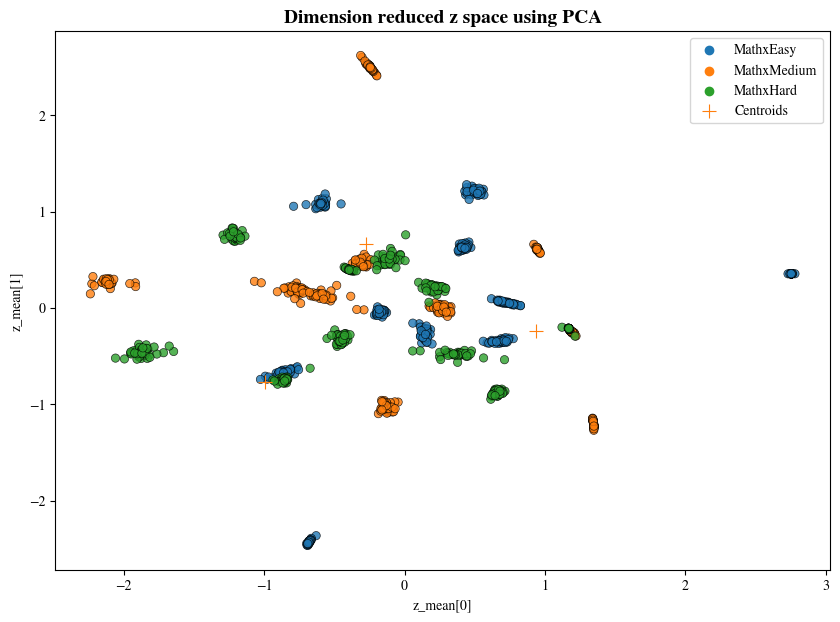

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using PCA", fontweight="bold", size=14)
sns.scatterplot(x=z_dim_reduced_pca[:,0], y=z_dim_reduced_pca[:,1], ax=ax, edgecolor="black", alpha=.8, hue=condition_df.values[:,0], palette="tab10")
sns.scatterplot(x=centroids[:,0], y=centroids[:, 1], marker="+", label="Centroids", s=100, edgecolor="black")
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

In [27]:
# Pick a Sample and recounstruct
sample_z_mean = np.array([[0, 0]])
sample_z_mean = pca.inverse_transform(sample_z_mean)

In [28]:
sample_z_mean_reconstructed = vae.decoder(sample_z_mean)

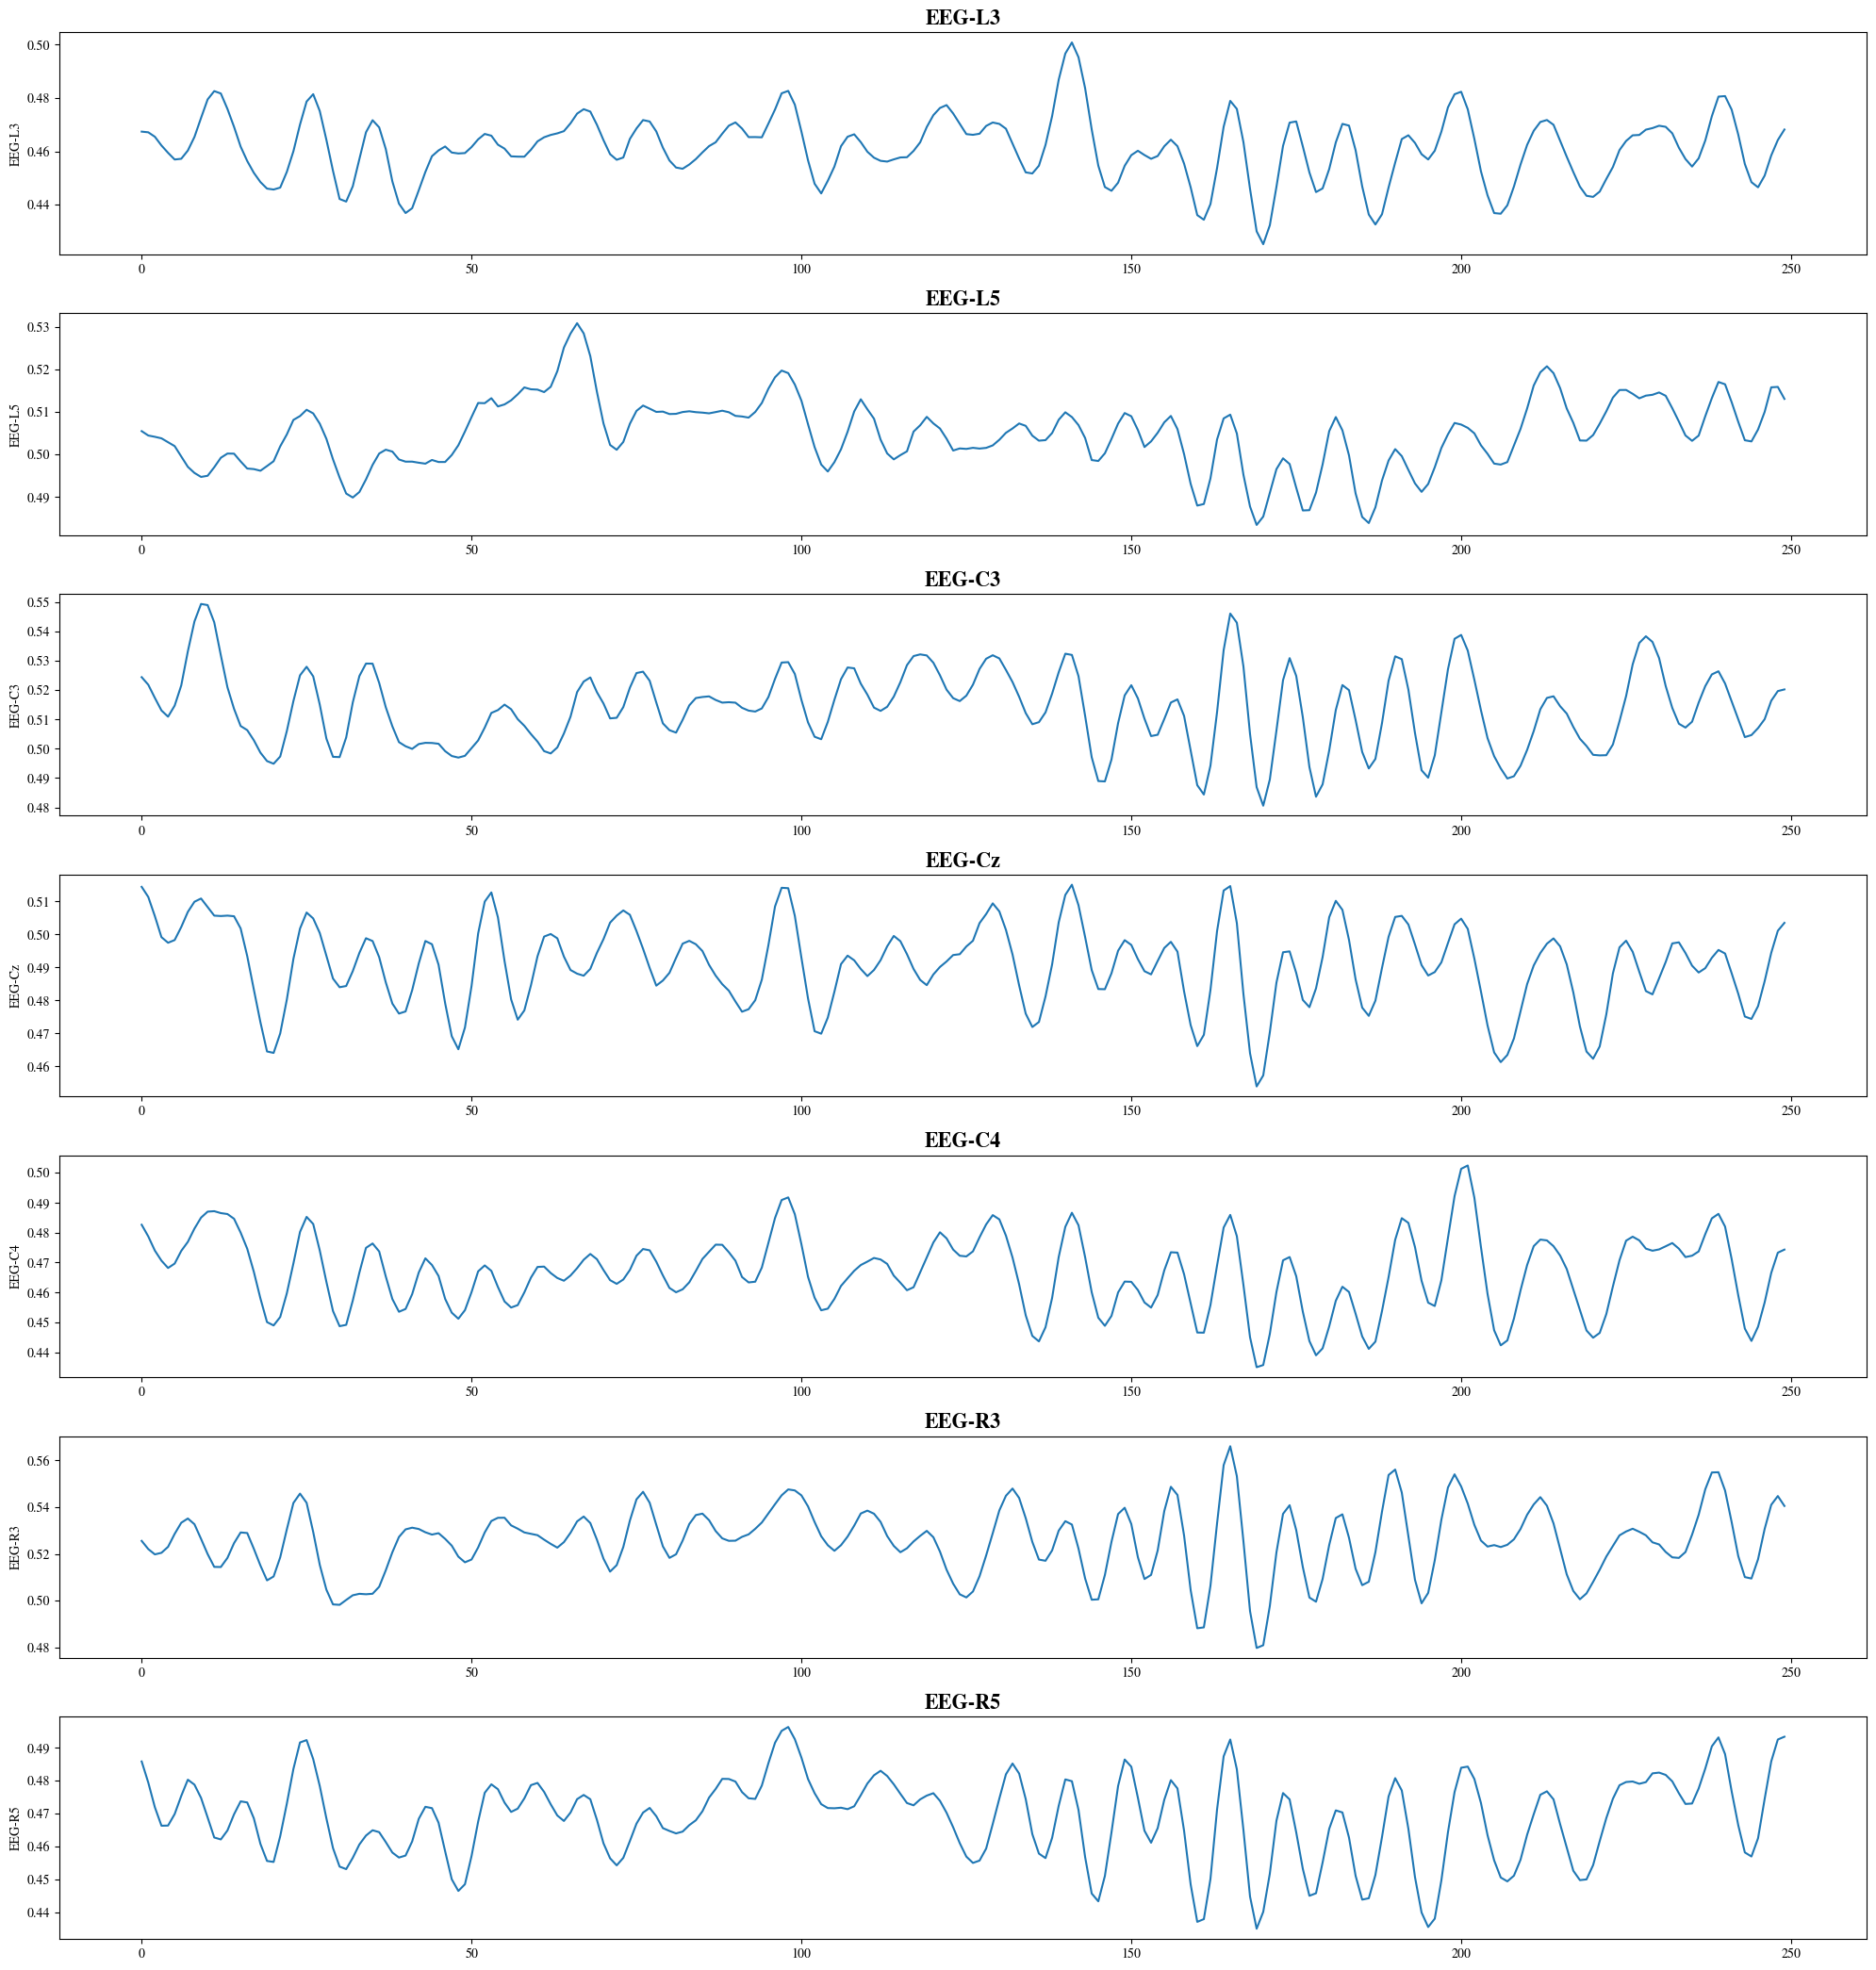

In [29]:
plot_all_time_series(sample_z_mean_reconstructed[0])

## Visualize Clusters

In [30]:
centroid_reconstructed = pca.inverse_transform(centroids)

In [31]:
samples_from_centroids = vae.decoder(centroid_reconstructed)

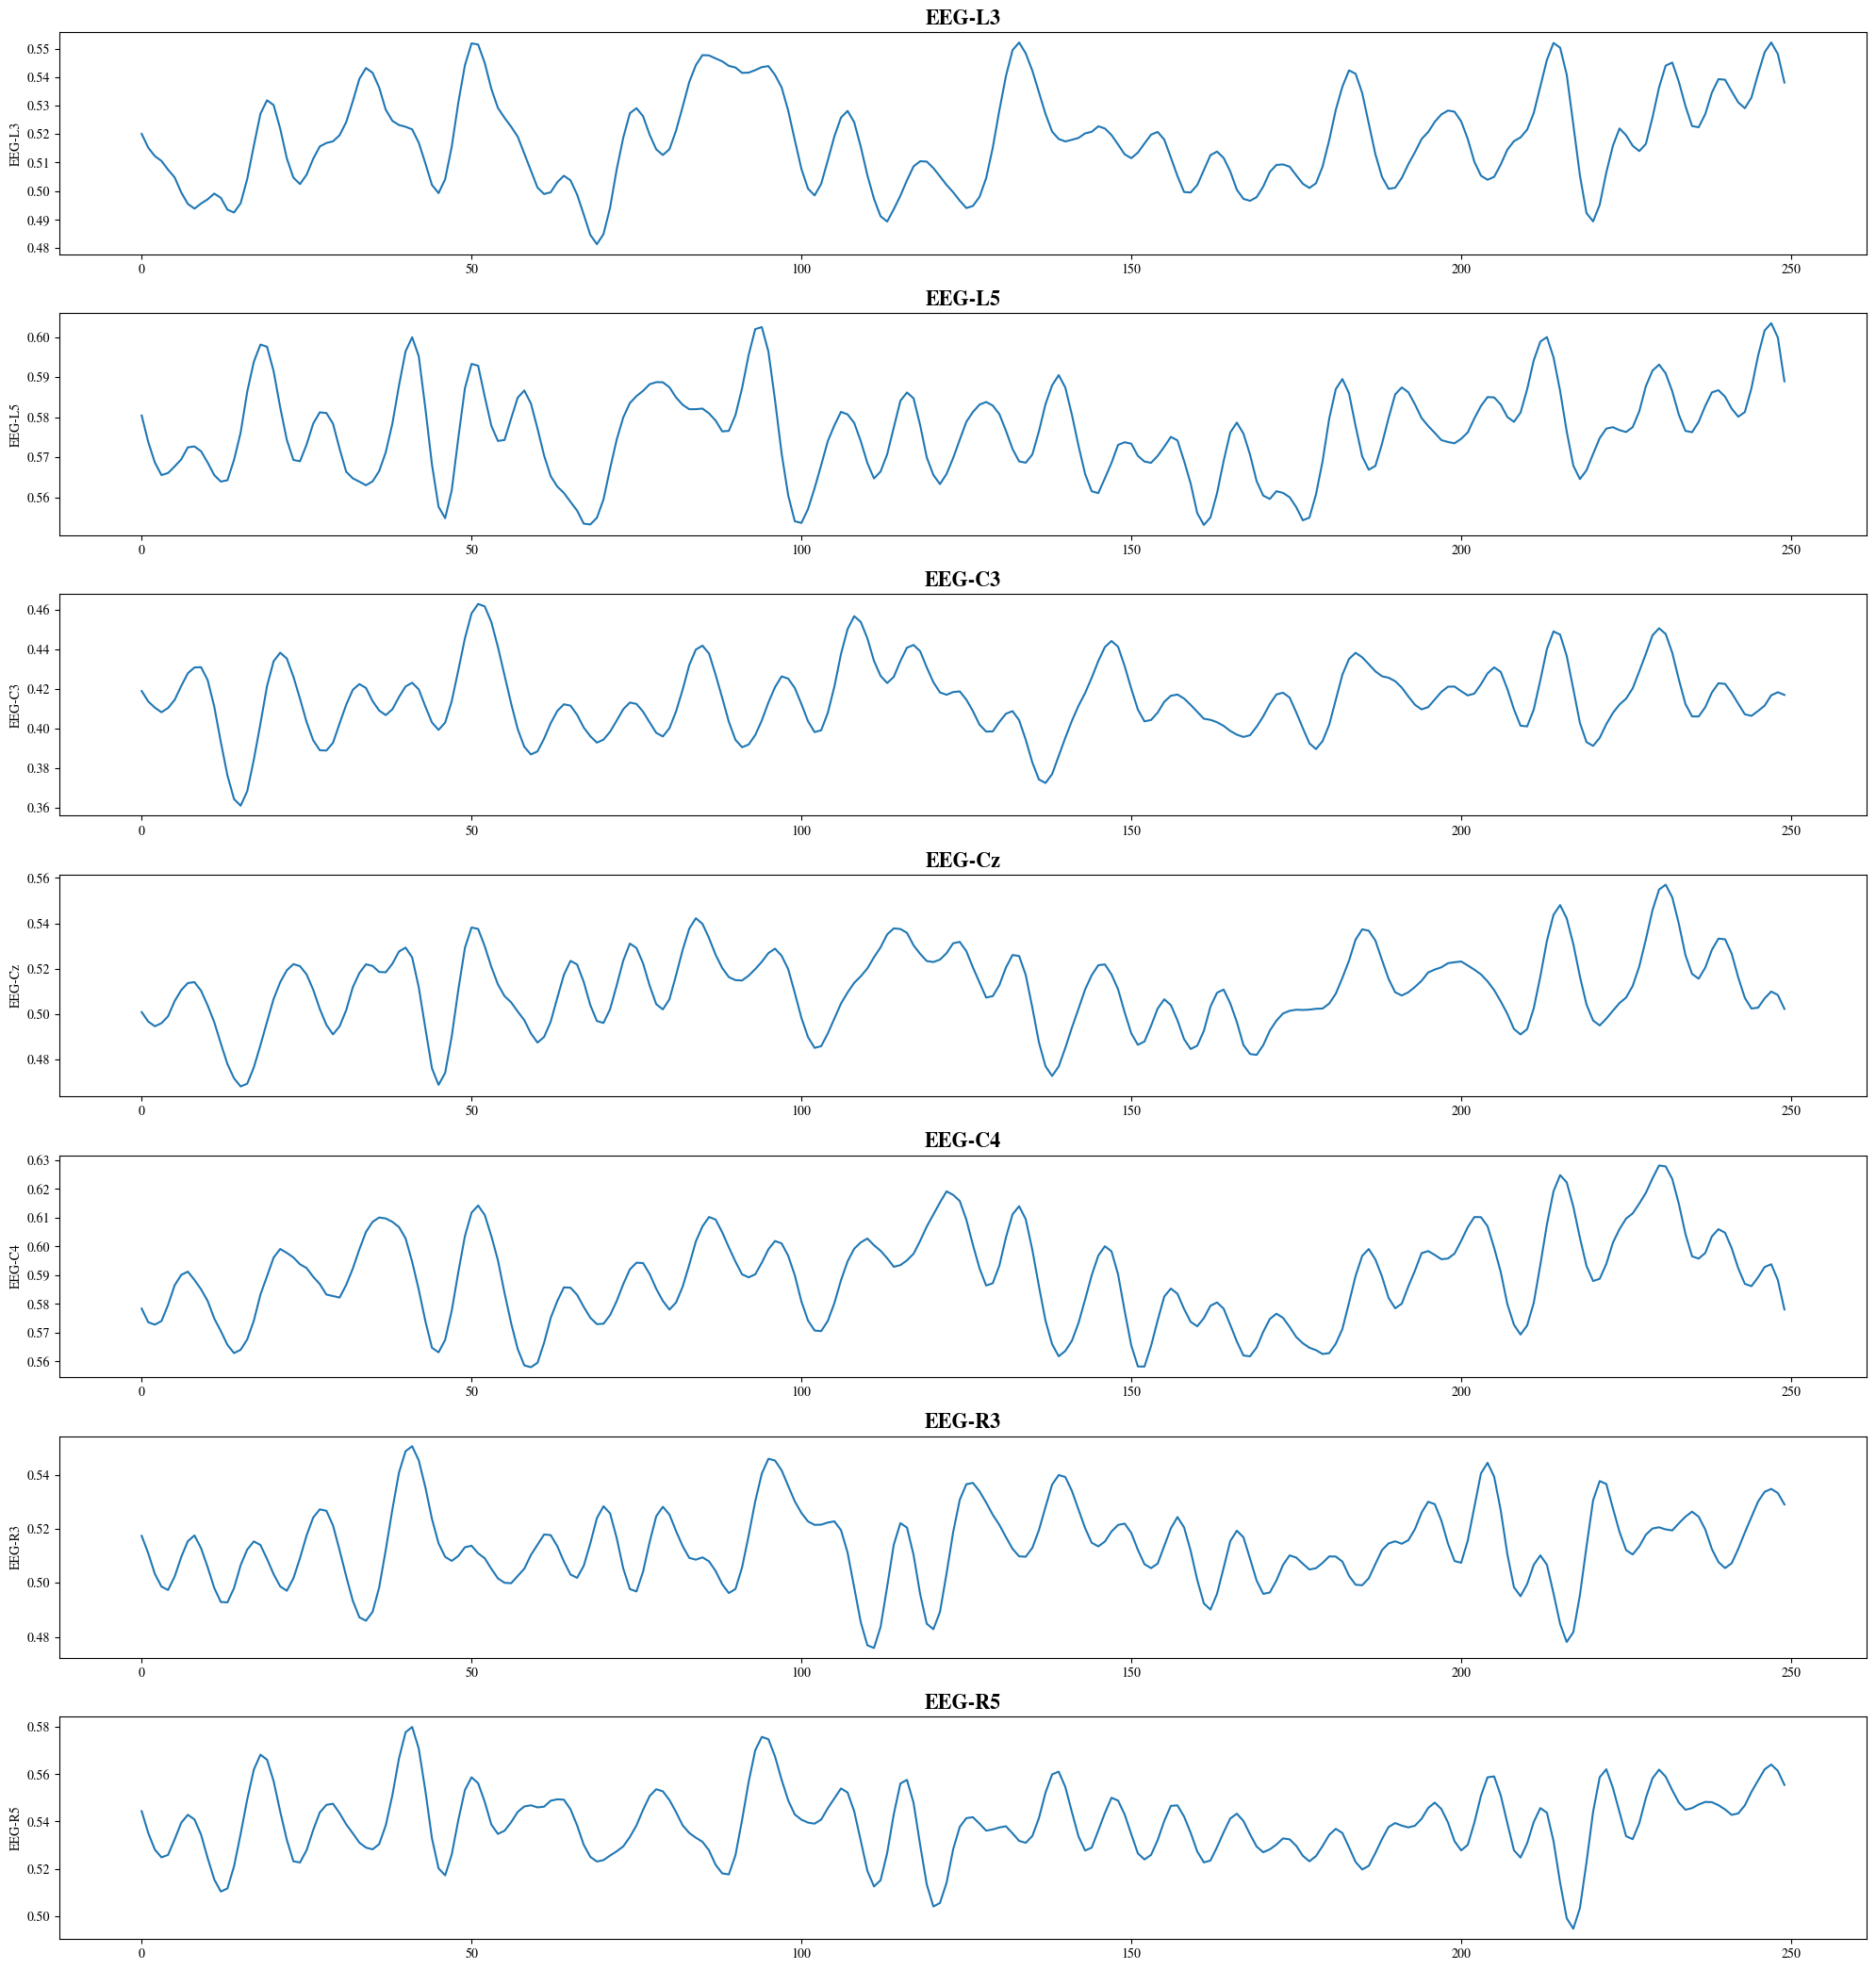

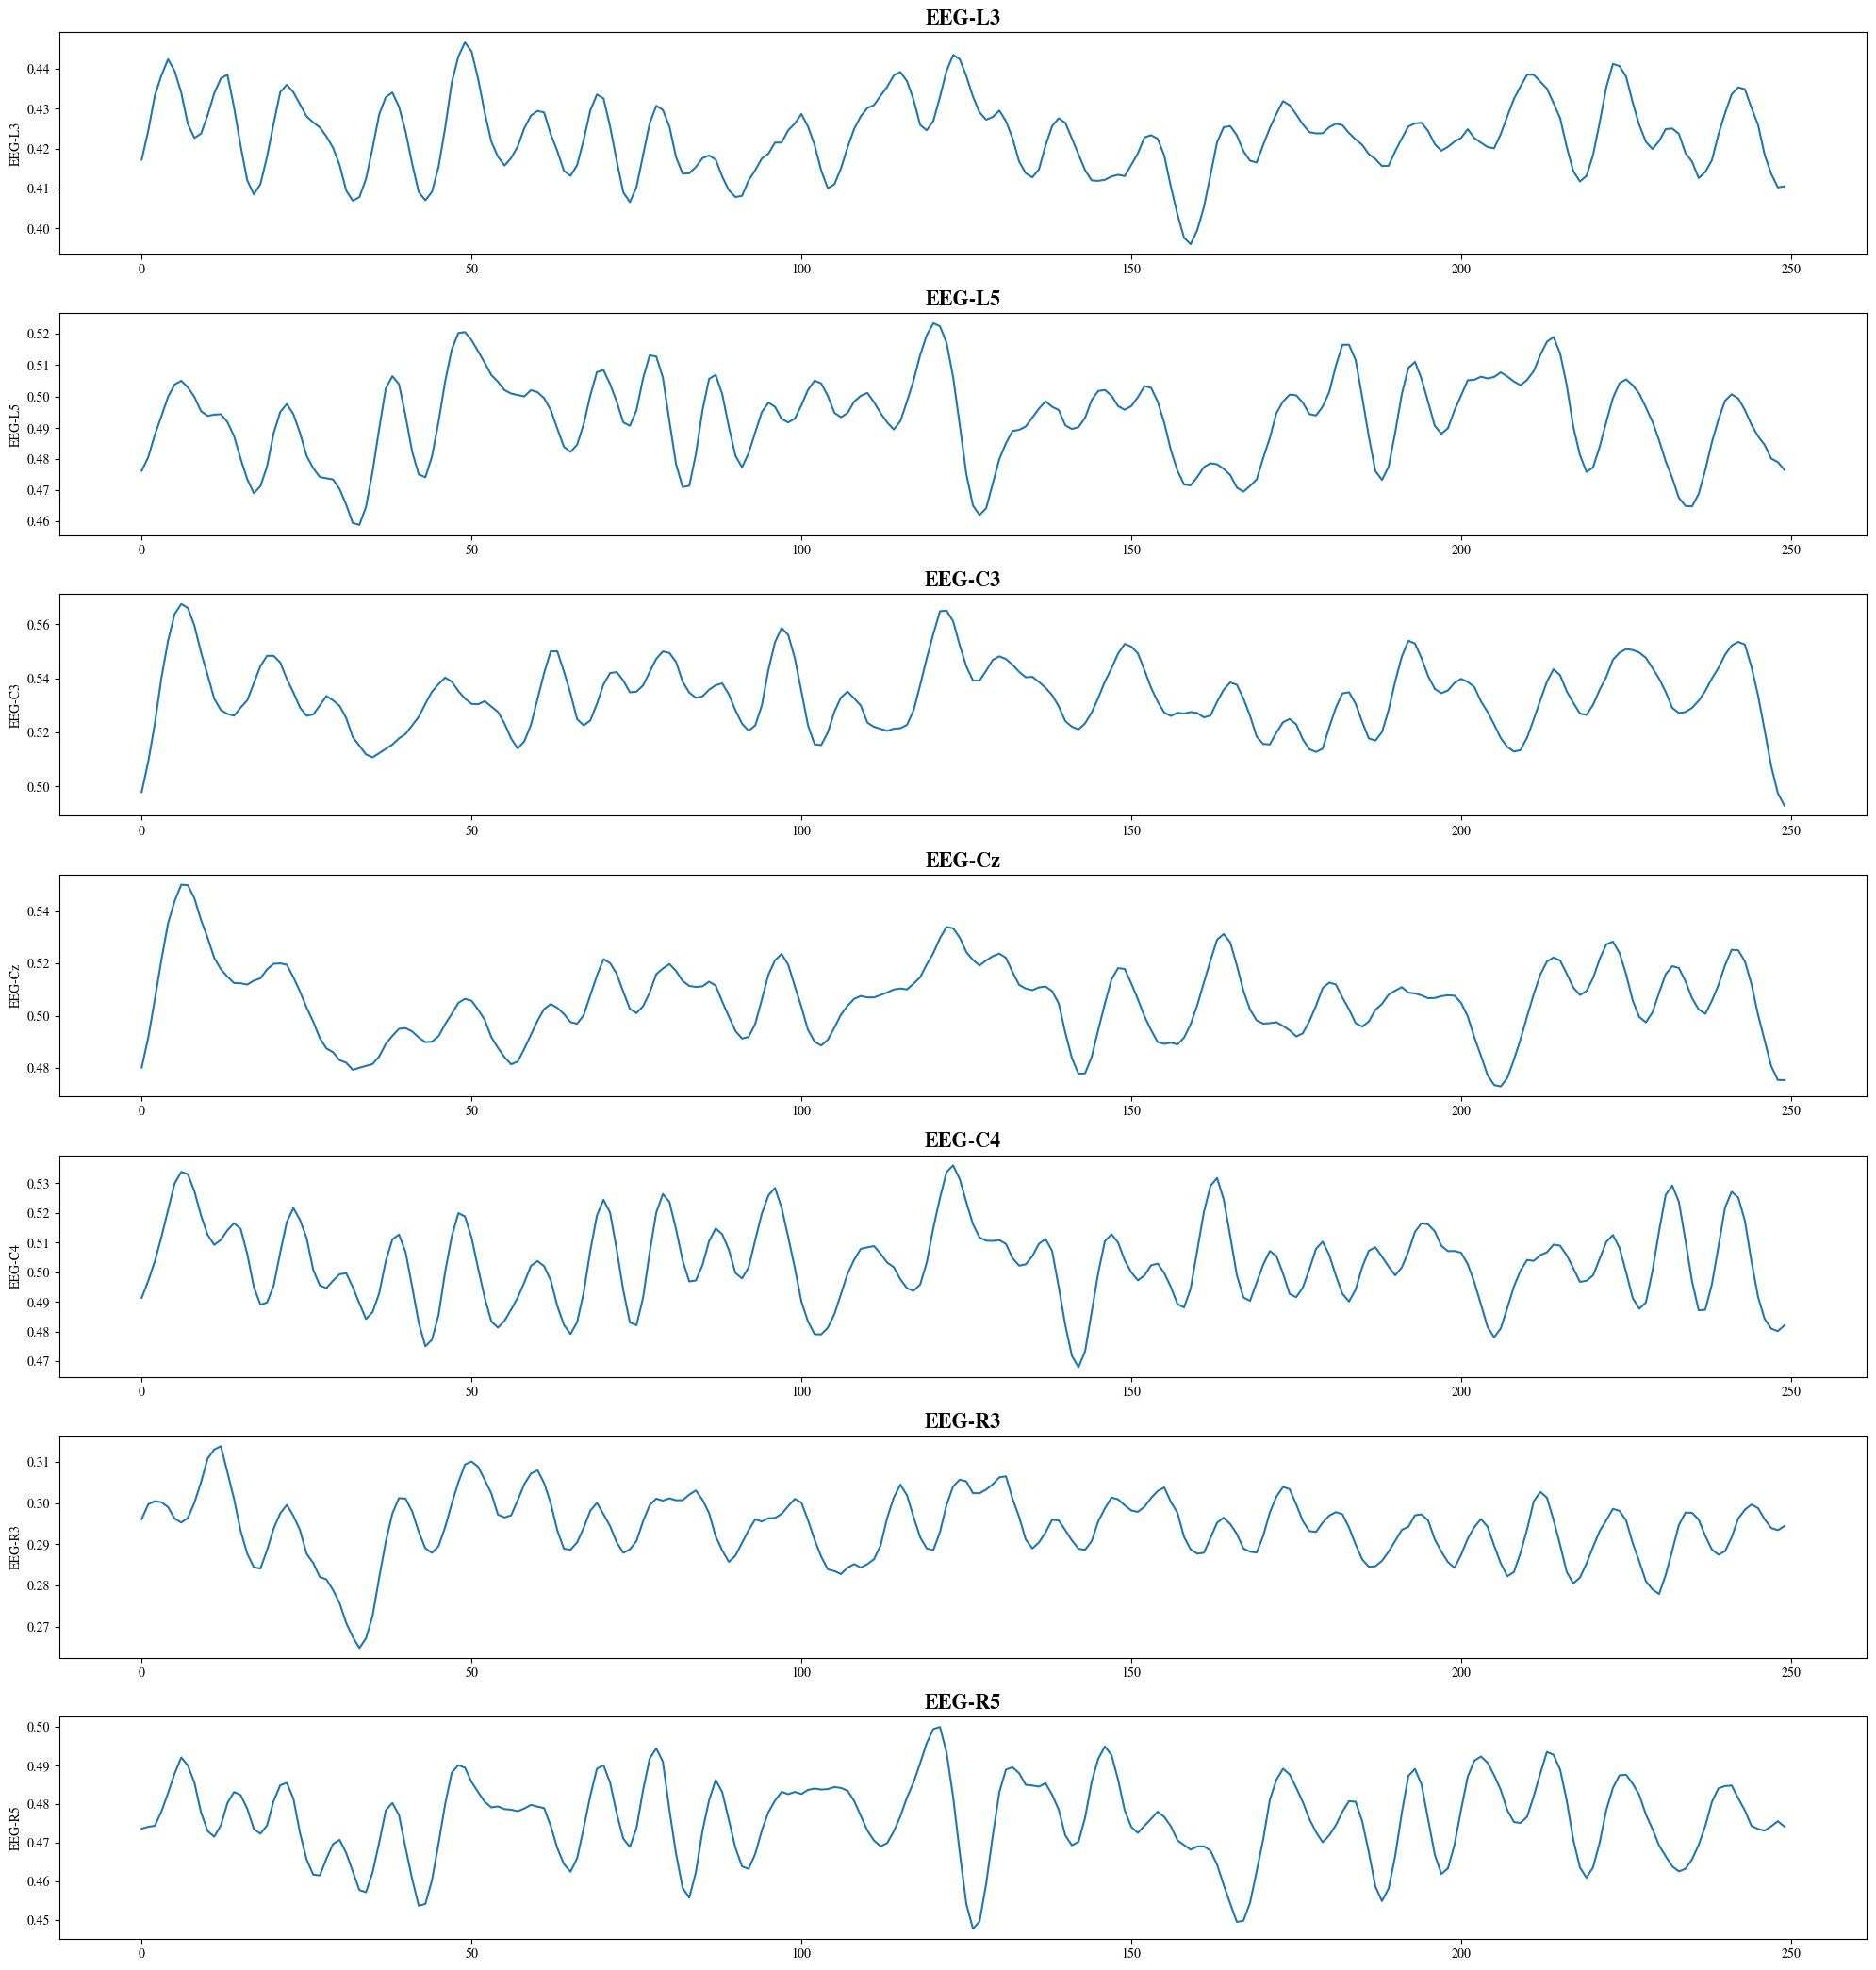

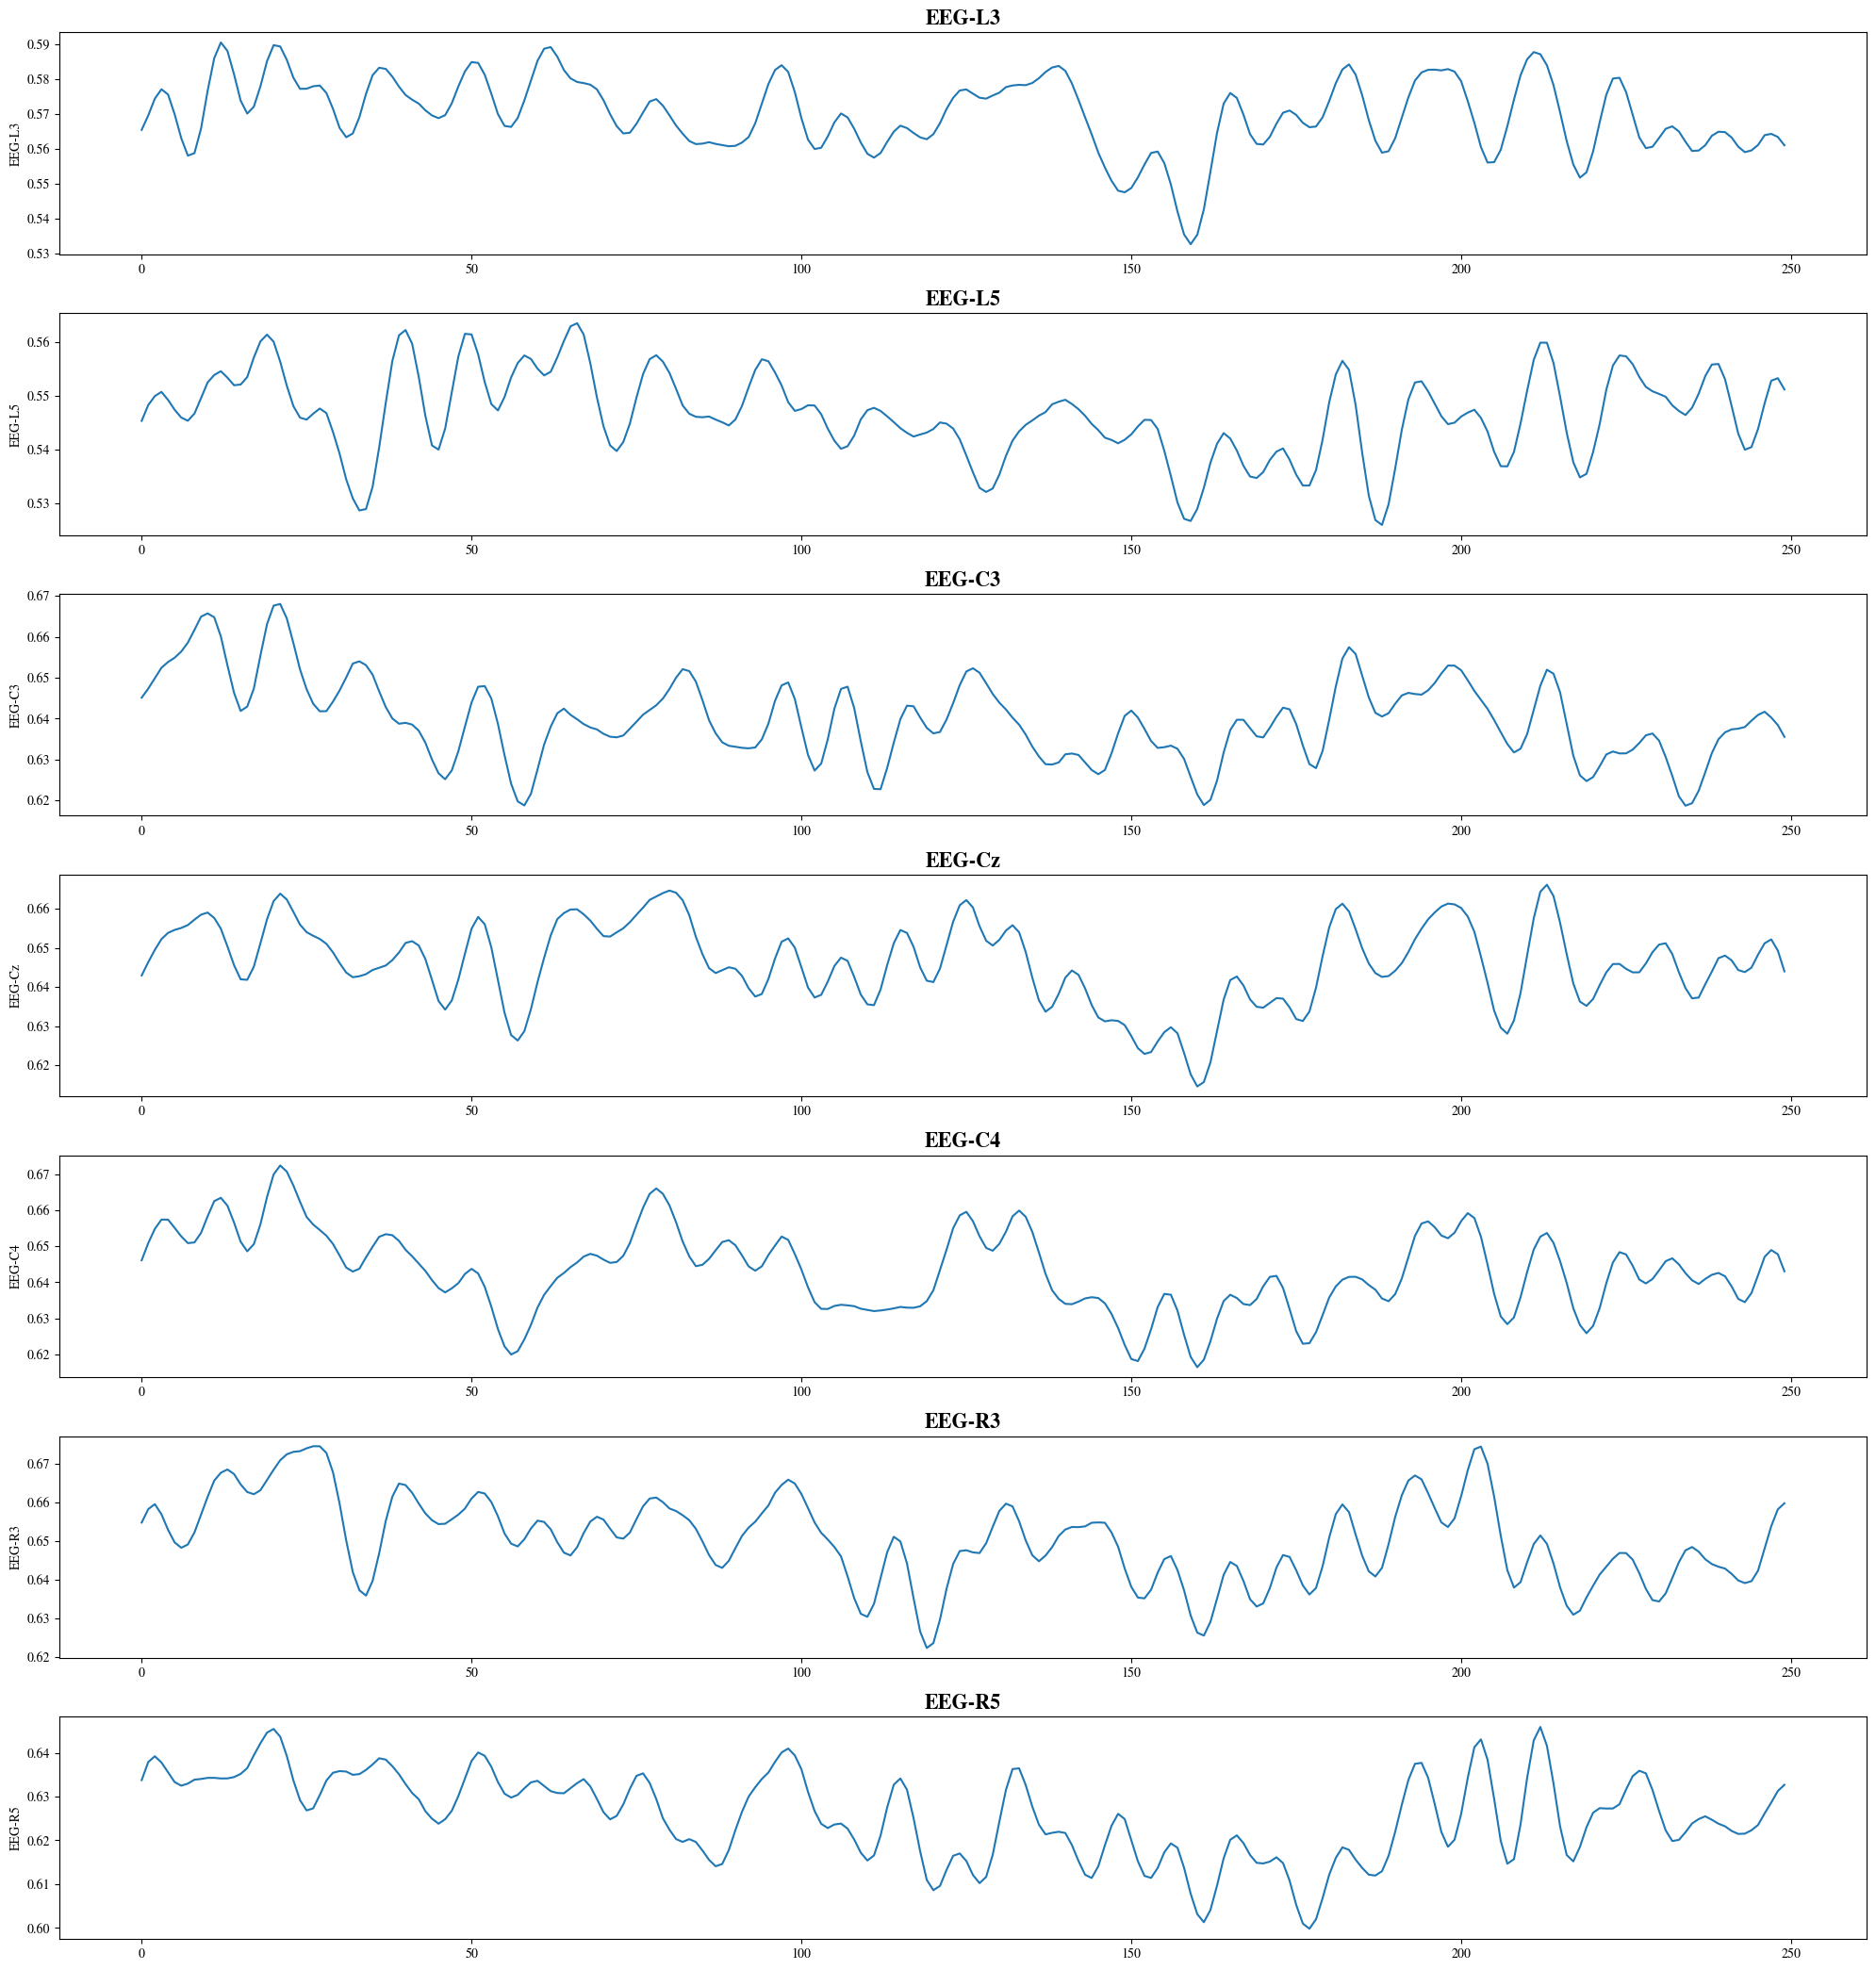

In [32]:
for i in range(samples_from_centroids.shape[0]):
    plot_all_time_series(samples_from_centroids[i])